# Demonstrate Dual UKF Estimation

In [1]:
from typing import List

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.advancedSOH import ECMASOH
from moirae.models.ecm.ins_outs import ECMInput, ECMMeasurement
from moirae.models.ecm.transient import ECMTransientVector
from moirae.models.ecm.simulator import ECMSimulator
from moirae.estimators.online.distributions import DeltaDistribution
from moirae.estimators.online.kalman.dual import DualUnscentedKalmanFilter as DualUKF

First, define a random number generator for consistency

In [2]:
# Initialize RNG
rng = np.random.default_rng(seed=1001001)

All examples in this notebook will use the same cycling protocol, which assumes every cycle starts with the cell at 100% SOC. This protocol follows the procedure below: 
1. rest the cell for 5-10 minutes
2. discharge the cell at a C-rate between 1.5 and 2.5 C
3. rest the cell for 10-20 minutes
4. charge the cell at a C-rate between 0.5 and 1.5 C
5. rest the cell for 5-10 minutes

We will create a helper function to specify timestamps and currents for a given cycle. These will be reported at 
approximately every second. 

In [3]:
def cycle_protocol(asoh: ECMASOH, start_time:float = 0.0) -> List[ECMInput]:
    """
    Function to return list of ECMInputs corresponding to a new cycle

    Args: 
        asoh: A-SOH object to be used
        start_time: time at which to start this cycle in seconds
    
    Returns:
        ecm_inputs: list of ECMInput objects corresponding to this cycle
    """
    # initialize main lists to be used
    timestamps = []
    currents = []

    # Get the Qt and CE, which will help determine the currents
    qt = asoh.q_t.amp_hour
    ce = asoh.ce

    # Now, let's choose rest durations and C-rates
    rest0, rest1, rest2 = rng.integers(low=5, high=10, size=3)
    rest0 *= 60
    rest1 *= 2 * 60
    rest2 *= 60
    dischg_rate, chg_rate = np.array([1.5, 0.5]) + rng.random(size=2)

    def update_timestamps_curr(duration: float, curr: float) -> None:
        """
        Helper to populate timestamps and currents.

        Args:
            duration: duration of segment in seconds
            curr: value of current to be used. 
        """
        # specify binds to nearest variables 
        nonlocal currents
        nonlocal timestamps
        new_len = int(np.ceil(duration))
        currents += [curr] * new_len
        new_times = np.sort(rng.random(size=new_len)) * duration
        if len(timestamps) == 0:
            new_times += start_time
        else:
            new_times += timestamps[-1] + (1.0e-03)
        timestamps += new_times.tolist()

    # Rest 0
    update_timestamps_curr(duration=rest0, curr=0.0)

    # Discharge
    dischg_duration = 3600.0 / dischg_rate
    dischg_curr = -(qt * dischg_rate)
    update_timestamps_curr(duration=dischg_duration, curr=dischg_curr)

    # Rest 1
    update_timestamps_curr(duration=rest1, curr=0.0)

    # Charge
    chg_duration = 3600.0 / chg_rate
    chg_curr = (qt * chg_rate) / ce
    update_timestamps_curr(duration=chg_duration, curr=chg_curr)

    # Rest 2
    update_timestamps_curr(duration=rest2, curr=0.0)

    # Finally, assemble the ECMInputs
    ecm_inputs = [ECMInput(time=time, current=current) for time, current in zip(timestamps, currents)]
    return ecm_inputs

## Example 1: Rint with no degradation

In our first example, we use a Rint model that does not degrade over time. For some additionaly complexity and demonstration purposes, we will use a SOC varying $R_0$, as shown below, where we prepare the Beginning of Life (BOL) A-SOH.

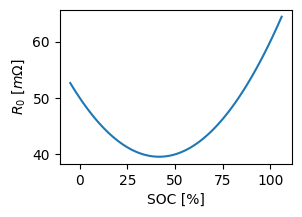

In [4]:
# Define the values of R0 to use
r0_vals = np.array([5,4,6]) * 1.0e-02

# Get A-SOH and set R0 values and interpolation style
asoh_rint_bol = ECMASOH.provide_template(has_C0=False, num_RC=0, R0=r0_vals)
asoh_rint_bol.r0.interpolation_style = 'quadratic'

# Check R0 profile
test_socs = np.arange(-0.05, 1.06, 0.01)
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(100 * test_socs, 1000 * asoh_rint_bol.r0.get_value(soc=test_socs))
ax.set_xlabel('SOC [%]')
_ = ax.set_ylabel(r'$R_0$ $[m\Omega]$')

Now, let's start preparations for the co-simulation of this cell alongside its joint estimation.

First, let us create a new A-SOH ground truth object with the proper updatable parameters set to help with the simulator and joint estimator. 

In [5]:
asoh_rint_gt = asoh_rint_bol.model_copy(deep=True)
# Check that nothing is updatable yet:
print('Initial updatable parameters: ', asoh_rint_gt.get_parameters())
asoh_rint_gt.mark_updatable(name='q_t.base_values')
asoh_rint_gt.mark_updatable(name='ce')
asoh_rint_gt.mark_updatable(name='r0.base_values')
asoh_rint_gt.mark_updatable(name='h0.base_values')
# Make sure we have all that is updatable

print('New updatable parameters: ', asoh_rint_gt.get_parameters())

Initial updatable parameters:  []
New updatable parameters:  [[10.    1.    0.05  0.04  0.06  0.05]]


Now, let's initialize the transient state to 100% SOC and create the simulator

In [6]:
transient0_rint_gt = ECMTransientVector.provide_template(has_C0=False, num_RC=0, soc=1.0)
rint_sim = ECMSimulator(asoh=asoh_rint_gt, transient_state=transient0_rint_gt, keep_history=True)

Since, in a real world setting, we don't exactly know the conditions of the cell when the estimator starts, we will perturb the transient state and the A-SOH to initialize the joint estimation. In order to perturb them appropriately, we should also establish their covariances, which will be needed for the UKF anyway.

For the transient state, we will assume that
1. the SOC variance is equivalent to that of a uniform distribution between 0 and 1
2. the hysteresis variance is equivalent to a uniform distribution from +M to -M (max hysteresis value)

For the A-SOH, we will assume that
1. the standard deviation of Qt is of 0.05 Amp-hour: $2\sigma=0.05\implies\sigma=2.5\times10^{-2}\implies\sigma^2=6.25\times10^{-4}$
2. the variance of coulombic efficiency is equivalent to that of a uniform distribution between 0.999 and 1
3. the standard deviation of all R0 base values is $2\sigma=1\times 10^{-2}\Omega\implies\sigma^2=2.5\times10^{-5}$
4. the hysteresis standard deviation if of 1 mV 

We should also print these perturbed values to make sure they are not too far out there (for instance, we would not want the SOC to be much larger than 105%)

In [7]:
# Start with the A-SOH
cov_asoh_rint = [6.25e-04] # Qt: +/- 0.05 Amp-hour
cov_asoh_rint += [(1.0e-06) / 12] # CE
cov_asoh_rint += (2.5e-05 * np.ones(3)).tolist() # R0
cov_asoh_rint += [1.0e-06] # hysteresis
cov_asoh_rint = np.diag(cov_asoh_rint)

# Now, the transient
cov_tran_rint = [1./12] # SOC
cov_tran_rint += [4 * (asoh_rint_gt.h0.base_values.item())**2 / 12] # hyst
cov_tran_rint = np.diag(cov_tran_rint)

# Generate perturbed values
tran_rint_off_array = rng.multivariate_normal(mean=transient0_rint_gt.to_numpy().squeeze(), cov=cov_tran_rint)
asoh_rint_off_array = rng.multivariate_normal(mean=asoh_rint_gt.get_parameters().squeeze(), cov=cov_asoh_rint)
# Make sure the initial SOC is not too off-base
while tran_rint_off_array[0] > 1.05:
    tran_rint_off_array[0] = rng.normal(loc=1.0, scale=cov_tran_rint[0,0])
# Let's also correct the Coulombic efficient, which cannot be larger than 1.
while asoh_rint_off_array[1] > 1:
    asoh_rint_off_array[1] = rng.normal(loc=1., scale=cov_asoh_rint[1,1])

# Finally, prepare the objects for the joint estimation
asoh_rint_off = asoh_rint_gt.model_copy(deep=True)
transient0_rint_off = transient0_rint_gt.model_copy(deep=True)
asoh_rint_off.update_parameters(asoh_rint_off_array)
transient0_rint_off.from_numpy(tran_rint_off_array)

# Check to make sure these were updated
print('Perturbed initial transient state: ', transient0_rint_off.to_numpy())
print('Perturbed A-SOH parameters: ', asoh_rint_off.get_parameters())

# Create joint estimator by setting very small noise terms for the A-SOH parameters
voltage_err = 1.0e-03 # mV voltage error
noise_sensor = ((voltage_err / 2) ** 2) * np.eye(1)
noise_asoh = 1.0e-10 * np.eye(len(asoh_rint_off_array))
noise_asoh[0, 0] = 6.25e-04 # Qt value is 10 Amp-hour, so +/- 0.05 Amp-hour is reasonable
noise_tran = 1.0e-08 * np.eye(2)

# Initialize DualUKF
rint_dual_ukf = DualUKF(
    model=ECM(),
    initial_asoh=asoh_rint_off,
    initial_transients=transient0_rint_off,
    initial_inputs=rint_sim.previous_input.model_copy(deep=True),
    initial_transient_covariance = cov_tran_rint,
    initial_asoh_covariance = cov_asoh_rint,
    covariance_transient_process_noise = noise_tran,
    covariance_asoh_process_noise = noise_asoh,
    covariance_sensor_noise = noise_sensor,
    normalize_asoh=False)

Perturbed initial transient state:  [[1.0471777  0.01302435]]
Perturbed A-SOH parameters:  [[9.9572639  0.99953508 0.03902681 0.04072698 0.06128874 0.05001693]]


In [8]:
asoh_rint_off_names = rint_dual_ukf.state_names
print(f'Updating {len(asoh_rint_off_names)} variables:', ', '.join(asoh_rint_off_names))

Updating 8 variables: soc, hyst, q_t.base_values, ce, r0.base_values[0], r0.base_values[1], r0.base_values[2], h0.base_values


We can now co-simulate the ECM and update the joint UKF!

In [9]:
# Total number of cycles to simulate
num_cycles = 5

# Let's also create a simple ways to store UKF predictions and estimates, as well as the inputs provided
noisy_voltage = []
controls = []
dual_ukf_predictions = {'joint_states': [], 'voltages': []}

# Specify the start time of the simulation
start_time = 0.0

for _ in tqdm(range(num_cycles)):
    # Generate list of inputs and store them in the controls
    protocol = cycle_protocol(asoh=rint_sim.asoh, start_time=start_time)
    controls += protocol

    for new_input in protocol:
        # Simulate (useful for also getting the real terminal voltage :) )
        _, cell_response = rint_sim.step(new_inputs=new_input)
        # Add noise to give to the UKF and store it
        vt = cell_response.terminal_voltage.item() + rng.normal(loc=0.0, scale=voltage_err / 2)
        noisy_voltage += [vt]
        # Step the joint estimator``
        measurement = ECMMeasurement(terminal_voltage=vt)
        est_hidden, pred_measure = rint_dual_ukf.step(
            u=new_input,
            y=measurement
        )
        # Save to the dictionary
        dual_ukf_predictions['joint_states'] += [est_hidden.model_copy(deep=True)]
        dual_ukf_predictions['voltages'] += [pred_measure.model_copy(deep=True)]

    # Update the start time of the next cycle
    start_time = protocol[-1].time.item() + 1.0e-03

100%|██████████| 5/5 [00:55<00:00, 11.06s/it]


In [11]:
dual_ukf_predictions['joint_states'][1]

MultivariateGaussian(mean=array([0.94192073, 0.01283416, 9.9572639 , 0.99953508, 0.03902681,
       0.04072698, 0.06128874, 0.05001693]), covariance=array([[ 2.05765304e-02, -1.08922529e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.08922529e-04,  8.33107510e-04,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.87500000e-03,
         6.75228000e-35,  8.44035000e-36,  0.00000000e+00,
         1.68807000e-35, -8.44035000e-36],
       [ 0.00000000e+00,  0.00000000e+00,  4.81482486e-35,
         8.35333333e-08,  4.57689215e-33, -2.79767655e-36,
         9.09998282e-33, -4.57320471e-33],
       [ 0.00000000e+00,  0.00000000e+00,  6.01853108e-36,
         4.57447293e-33,  2.50002000e-05, -3.49709569e-37,
         1.12857585e-33, -5.79978966e-34],
       [ 0.00000000e+00,  0.00000000e+00,  0.0

Now, collect and process the results for visualization

In [12]:
# Controls
timestamps = np.array([control.time.item() for control in controls]) / 3600
currents = np.array([control.current.item() for control in controls])

# Get real values
real_soc = np.array([transient.soc.item() for transient in rint_sim.transient_history])
real_hyst = np.array([transient.hyst.item() for transient in rint_sim.transient_history])

# Estimate values and their corresponding uncertainty
estimated = pd.DataFrame([estimate.get_mean() for estimate in dual_ukf_predictions['joint_states']], columns=asoh_rint_off_names)
estimated_std = pd.DataFrame([np.sqrt(np.diag(estimate.get_covariance())) for estimate in dual_ukf_predictions['joint_states']], columns=asoh_rint_off_names)
predicted_Vt = np.array([prediction.mean[0] for prediction in dual_ukf_predictions['voltages']])
predicted_Vt_std = np.sqrt(np.array([prediction.covariance[0,0] for prediction in dual_ukf_predictions['voltages']]))

First, let's check that the voltage predictions are acceptable.

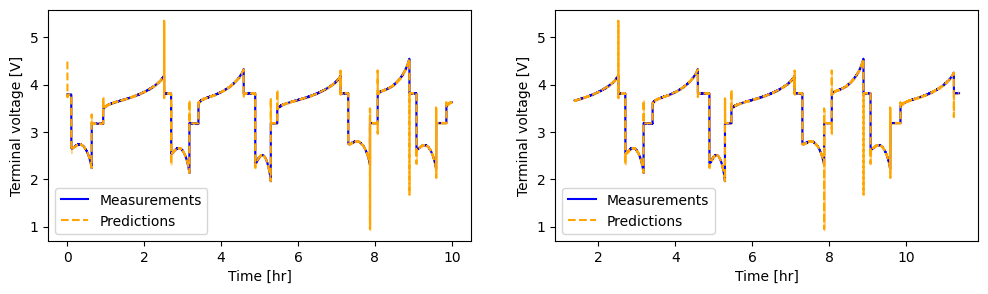

In [13]:
# Choose the first and last entries to plot for clarity
first_entries = 36000
last_entries = 36000

fig, axes = plt.subplots(1,2,figsize=(12,3))
axes[0].plot(timestamps[:first_entries],
             noisy_voltage[:first_entries],
             color='blue',
             label='Measurements')
axes[0].plot(timestamps[:first_entries],
             predicted_Vt[:first_entries],
             linestyle='--',
             color='orange',
             label='Predictions')
axes[0].fill_between(timestamps[5:first_entries],
                     (predicted_Vt + 2*predicted_Vt_std)[5:first_entries],
                     (predicted_Vt - 2*predicted_Vt_std)[5:first_entries],
                     color='orange',
                     alpha=0.5,
                     zorder=0)
axes[1].plot(timestamps[-last_entries:],
             noisy_voltage[-last_entries:],
             color='blue',
             label='Measurements')
axes[1].plot(timestamps[-last_entries:],
             predicted_Vt[-last_entries:],
             linestyle='--',
             color='orange',
             label='Predictions')
axes[1].fill_between(timestamps[-last_entries:],
                     (predicted_Vt + 2*predicted_Vt_std)[-last_entries:],
                     (predicted_Vt - 2*predicted_Vt_std)[-last_entries:],
                     color='orange',
                     alpha=0.5,
                     zorder=0)

for ax in axes:
    ax.legend()
    ax.set_xlabel('Time [hr]')
    ax.set_ylabel('Terminal voltage [V]')


Now, let's take a look at the progression of the physical transient hidden vector.

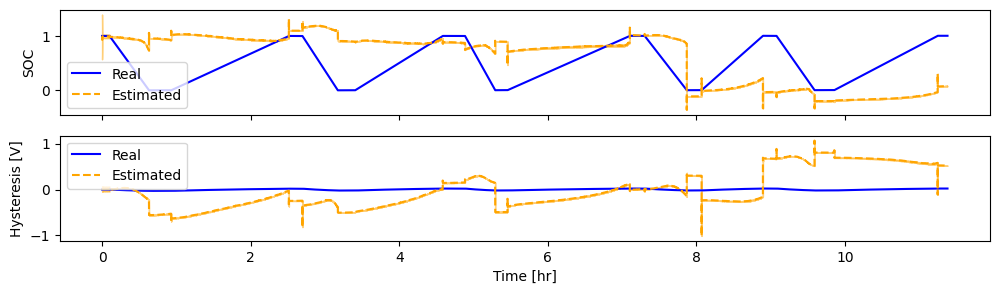

In [14]:
fig, axes = plt.subplots(2, 1, sharex='col', figsize=(12,3))
axes[0].plot(timestamps,
             real_soc[1:],
             color='blue',
             label='Real')
axes[0].plot(timestamps[:len(estimated)],
             estimated['soc'],
             linestyle='--',
             color='orange',
             label='Estimated')
axes[0].fill_between(timestamps[:len(estimated)],
                     (estimated['soc'] + 2*estimated_std['soc']),
                     (estimated['soc'] - 2*estimated_std['soc']),
                     color='orange',
                     alpha=0.5,
                     zorder=0)
axes[1].plot(timestamps,
             real_hyst[1:],
             color='blue',
             label='Real')
axes[1].plot(timestamps[:len(estimated)],
             estimated['hyst'],
             linestyle='--',
             color='orange',
             label='Estimated')
axes[1].fill_between(timestamps[:len(estimated)],
                     (estimated['hyst'] + 2*estimated_std['hyst']),
                     (estimated['hyst'] - 2*estimated_std['hyst']),
                     color='orange',
                     alpha=0.5,
                     zorder=0)

axes[0].set_ylabel('SOC')
axes[1].set_ylabel('Hysteresis [V]')
axes[-1].set_xlabel('Time [hr]')
for ax in axes:
    ax.legend()

Finally, let's see if the A-SOH parameters reached a correct, stable value.

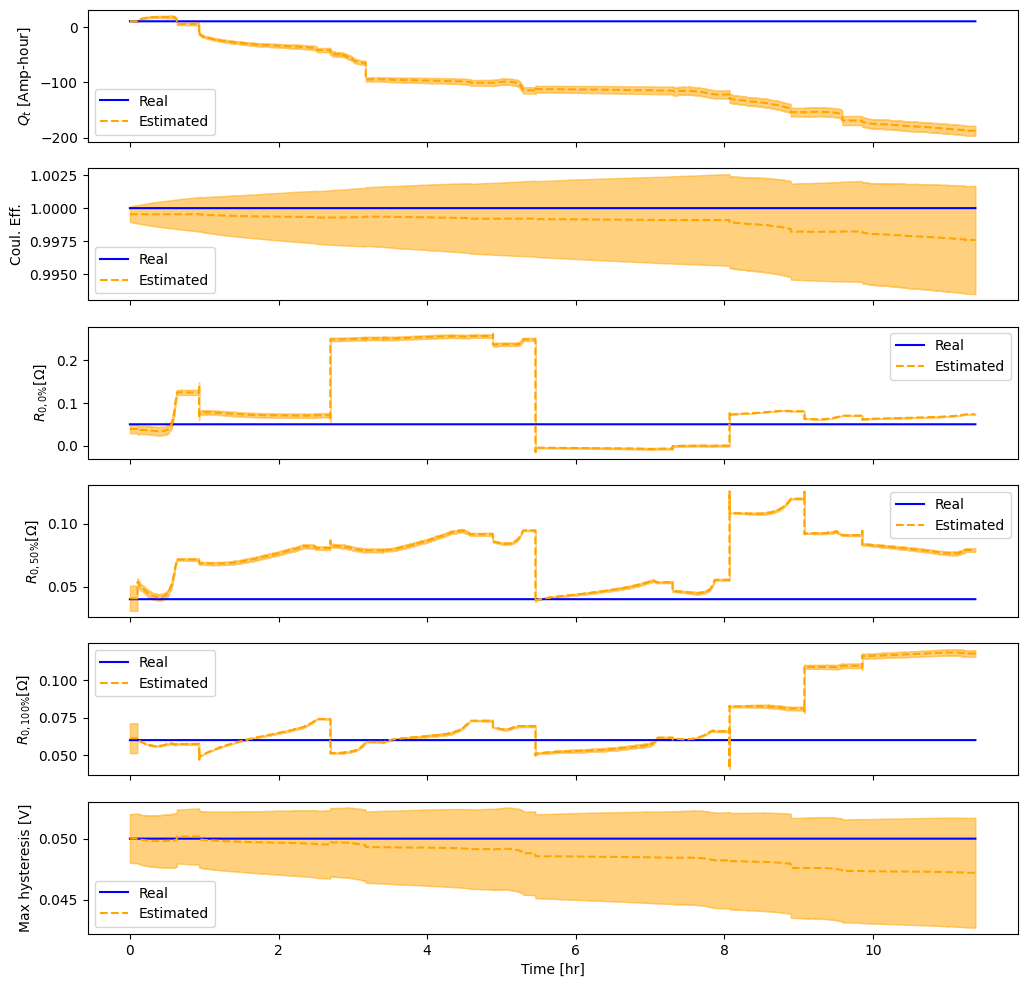

In [15]:
fig, axes = plt.subplots(6, 1, sharex='col', figsize=(12,12))

# Let us simplify plotting
real_parameter_values = asoh_rint_gt.get_parameters()[0, :]
# estimated_parameters = [estimated_Qt, estimated_CE]
# estimated_parameters += [estimated_R0[:,0]]
# estimated_parameters += [estimated_R0[:,1]]
# estimated_parameters += [estimated_R0[:,2]]
# estimated_parameters += [estimated_H0]
# estimated_uncertainties = [2 * estimated_Qt_std, 2 * estimated_CE_std]
# estimated_uncertainties += [2 * estimated_R0_std[:,0,0]]
# estimated_uncertainties += [2 * estimated_R0_std[:,1,1]]
# estimated_uncertainties += [2 * estimated_R0_std[:,2,2]]
# estimated_uncertainties += [2 * estimated_H0_std]
parameter_names = [r'$Q_t$ [Amp-hour]', 'Coul. Eff.', \
                   r'$R_{0,0\%} [\Omega]$', r'$R_{0,50\%} [\Omega]$', r'$R_{0,100\%} [\Omega]$', 'Max hysteresis [V]']

axes[-1].set_xlabel('Time [hr]')

for i, ax in enumerate(axes):
    param_val = real_parameter_values[i]
    est, est_std = estimated.iloc[:, i + 2], estimated_std.iloc[:, i + 2]  # There are two transient columns at the beginning
    ax.plot(timestamps[:len(estimated['q_t.base_values'])],
            [param_val] * len(estimated['q_t.base_values']),
            color='blue',
            label='Real')
    ax.plot(timestamps[:len(estimated)],
            est,  # There are two transient columns at the beginning
            color='orange',
            linestyle='--',
            label='Estimated')
    ax.fill_between(timestamps[:len(estimated)],
                    (est + est_std * 2),
                    (est - est_std * 2),
                    color='orange',
                    alpha=0.5)
    ax.legend()
    ax.set_ylabel(parameter_names[i])